In [2]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
import numpy as np

In [377]:
class AdaBoost(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_classifier, n_classifiers = 200,
                learning_rate = 0.5):
        self.base_classifier = base_classifier
        self.learning_rate = learning_rate
        self.n_classifiers = n_classifiers
        
    def predict(self, X):
        y = np.zeros((X.shape[0],))
        predictions = []
        stacked_prediction = None
        
        for classifier in self.classifiers:
            predictions.append(classifier.predict(X).reshape(-1,1))
        
        stacked_prediction = np.hstack(predictions)
        stacked_as = np.repeat(self.a_vector.T, X.shape[0], axis=0)
        
        class_scores = []
        
        for i, c in enumerate(self.classes):
            class_score = np.sum(
                np.multiply(stacked_as, (stacked_prediction==c).astype(int)), axis=1).reshape(-1,1)
            class_scores.append(class_score)
            
        class_result = np.hstack(class_scores)
        class_indices = np.argmax(class_result, axis=1)
        
        for i, index in enumerate(class_indices):
            y[i] = self.class_indices[index[0,0]]
    
        return y
    
    def fit(self, X, y):
        self.a_scores = []
        self.classifiers = []
        self.base_weight = np.ones_like(y)/len(y)
        
        self.classes = []
        self.class_indices = {}
        
        for entry in y:
            if entry not in self.classes:
                self.classes.append(entry)      
                self.class_indices[entry] = len(self.classes)-1
        
                
        while len(self.classifiers) < self.n_classifiers:
            new_classifier = clone(self.base_classifier)
            new_classifier.fit(X, y, sample_weight = self.base_weight)
            
            self.classifiers.append(new_classifier)
            
            new_prediction = new_classifier.predict(X)
            
            w_sum = np.sum(self.base_weight)
            w_n_sum = np.sum(self.base_weight[y!=new_prediction])
            
            r = w_n_sum/w_sum
            
            a = self.learning_rate*np.log((1-r)/r)
            self.a_scores.append(a)
            
            self.base_weight[y!=new_prediction] *= np.exp(a)
            self.base_weight /= np.sum(self.base_weight)
        
        self.a_vector = np.matrix(self.a_scores).reshape(-1, 1)
        
        return self

In [378]:
from sklearn.datasets import make_moons

In [379]:
X, y = make_moons(n_samples = 1000, noise=0.25)

In [380]:
import matplotlib.pyplot as plt

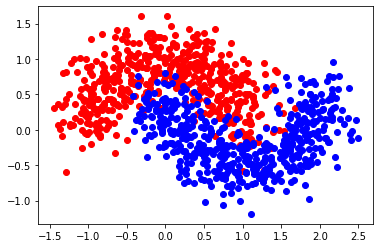

In [381]:
plt.scatter(X[y==0,0],X[y==0,1], color="red")
plt.scatter(X[y==1,0],X[y==1,1], color="blue")
plt.show()

In [390]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

custom_adaboost = AdaBoost(DecisionTreeClassifier(max_depth=1))

In [391]:
np.mean(cross_val_score(custom_adaboost, X, y, scoring="accuracy", cv=25))

0.929

In [392]:
from sklearn.ensemble import AdaBoostClassifier

In [393]:
sklearn_adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

In [394]:
np.mean(cross_val_score(sklearn_adaboost, X, y, scoring="accuracy", cv=25))

0.9289999999999999

In [471]:
from sklearn.base import RegressorMixin

class GradientBoosting(BaseEstimator, RegressorMixin):
    
    def __init__(self, base_estimator, n_estimators, learning_rate = 1.0):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
    def predict(self, X):
        result = np.zeros((X.shape[0], ))
        
        for estimator in self.estimators:
            result += self.learning_rate*estimator.predict(X)
        
        return result
        
    def fit(self, X, y):
        residual = y
        self.estimators = []
        
        while len(self.estimators) < self.n_estimators:
            new_estimator = clone(self.base_estimator)
            new_estimator.fit(X, residual)
            self.estimators.append(new_estimator)
            residual = residual - self.learning_rate*new_estimator.predict(X)
        
        return self        

Let's generate a sample dataset for this prediction.

In [472]:
xx, yy = np.meshgrid(np.linspace(0, 1, 30), np.linspace(0, 1, 30))
y = np.sin(xx*2+yy*2).flatten()
y += np.random.rand(*y.shape)/2

X = np.dstack([xx.flatten(), yy.flatten()])[0]

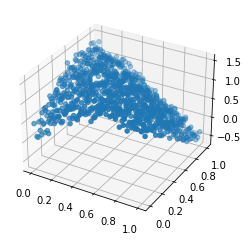

In [473]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(xx, yy, y)

In [489]:
from sklearn.tree import DecisionTreeRegressor

gbr_custom = GradientBoosting(DecisionTreeRegressor(max_depth=2), n_estimators = 50, learning_rate=0.4)

In [490]:
np.mean(-cross_val_score(gbr_custom, X, y, scoring="neg_mean_squared_error", cv=30))

0.027444965982262412

In [491]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_sklearn = GradientBoostingRegressor(max_depth = 2, n_estimators = 50, learning_rate = 0.4)

In [492]:
np.mean(-cross_val_score(gbr_sklearn, X, y, scoring="neg_mean_squared_error", cv=30))

0.027444965982354744

Let's see how the reqression looks like.

In [494]:
gbr_custom.fit(X, y)
ypred = gbr_custom.predict(X)

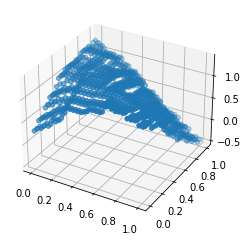

In [495]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(xx, yy, ypred)

The prediction looks quite smooth and well-fit.